# 1. Install and Import Libraries

Here we'll install and import all the required libraries for our analysis

In [1]:
import pandas as pd 
import numpy as np

# Set Display Options
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

import requests
from pandas.io.json import json_normalize
import json

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

# Install Folium and Geopy
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes

import folium

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  35.43 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  18.44 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  19.22 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  24.24 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |###################

# 2. Import and Prepare Data

<strong>2.1 Scrap Totonto Neighbourhood data from wikipedia html table</strong>

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df.head()

0             1                 2
0  Postcode       Borough     Neighbourhood
1       M1A  Not assigned      Not assigned
2       M2A  Not assigned      Not assigned
3       M3A    North York         Parkwoods
4       M4A    North York  Victoria Village

<strong>2.2 Convert the first row from the scrapped data as the Column headers</strong> 

In [3]:
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.head()

0 Postcode           Borough     Neighbourhood
1      M1A      Not assigned      Not assigned
2      M2A      Not assigned      Not assigned
3      M3A        North York         Parkwoods
4      M4A        North York  Victoria Village
5      M5A  Downtown Toronto      Harbourfront

<strong>2.3 Drop the Rows where the value of 'Borough' column is 'Not Assigned'</strong>

In [4]:
df = df.dropna()
df = df[df.Borough != 'Not assigned']
df = df.replace('\n','', regex=True)
df = df.groupby(['Postcode','Borough'], sort=False).agg( ','.join)
df.reset_index(inplace = True)
df[df.Neighbourhood == 'Not assigned']

0 Postcode       Borough Neighbourhood
4      M7A  Queen's Park  Not assigned

<strong>2.4 Replace the 'Neighbourhood' value with 'Borough' value if its value is 'Not Assigned' and check</strong>

In [5]:
df.loc[df.Neighbourhood == 'Not assigned', 'Neighbourhood'] = df['Borough']

In [6]:
df[df.Postcode == 'M7A']

0 Postcode       Borough Neighbourhood
4      M7A  Queen's Park  Queen's Park

<strong>2.5 Check the dimension of the dataframe</strong>

In [7]:
df.shape

(103, 3)

<strong>2.6 Create new columns 'Latitude' and 'Longitude' in 'df' dataframe with the value '0'</strong>

In [ ]:
df['Latitude'] = '0';
df['Longitude'] = '0';

<strong>2.7 Import Geographical data for Toronto Neighbourhood</strong>

In [8]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

<strong><p>2.8 Combine the Toronto Neighbourhood dataframe with the Toronto Geographical Dataframe. 
It'll run loop for both dataframe. </p>
<p>Condition is, If the first column of 'df' matched with the first column of 'df_geo',
it'll replace the 'df' column 'Latitude' with the value of 'df_geo' column 'Latitude'
and also replace the 'df' column 'Longitude' with the value of 'df_geo' column 'Longitude'</strong>

In [9]:
for i in df.index:
    for j in df_geo.index:
        if df.iloc[i, 0] == df_geo.iloc[j, 0]:
            df.iloc[i, 3] = df_geo.iloc[j, 1]
            df.iloc[i, 4] = df_geo.iloc[j, 2]
            
df.head(12)

0  Postcode           Borough  \
0       M3A        North York   
1       M4A        North York   
2       M5A  Downtown Toronto   
3       M6A        North York   
4       M7A      Queen's Park   
5       M9A         Etobicoke   
6       M1B       Scarborough   
7       M3B        North York   
8       M4B         East York   
9       M5B  Downtown Toronto   
10      M6B        North York   
11      M9B         Etobicoke   

0                                       Neighbourhood Latitude Longitude  
0                                           Parkwoods  43.7533  -79.3297  
1                                    Victoria Village  43.7259  -79.3156  
2                            Harbourfront,Regent Park  43.6543  -79.3606  
3                     Lawrence Heights,Lawrence Manor  43.7185  -79.4648  
4                                        Queen's Park  43.6623  -79.3895  
5                                    Islington Avenue  43.6679  -79.5322  
6                                       Rouge,Malvern  43.8067  -79.1944  
7                                     Don Mills North  43.7459  -79.3522  
8                      Woodbine Gardens,Parkview Hill  43.7064  -79.3099  
9                             Ryerson,Garden District  43.6572  -79.3789  
10                                          Glencairn  43.7096  -79.4451  
11  Cloverdale,Islington,Martin Grove,Princess Gar...  43.6509  -79.5547

<strong>2.9 Find the Latitude and Longitude for Toronto</strong>

In [10]:
address = 'Toronto, Ontario'

locator = Nominatim(user_agent="tl-toronto-neigh")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Latitude and Longitude for Toronto "{}" & "{}".'.format(latitude, longitude))

Latitude and Longitude for Toronto "43.653963" & "-79.387207".


<strong>2.10 Our goal is to work with the data for Toronto. So, here we'll filter the data where the column 'Borough' contains the keyword 'Toronto'</strong>

In [11]:
df_toronto = df.copy()
df_toronto = df_toronto[df.Borough.str.contains("Toronto")]
df_toronto.head()

0  Postcode           Borough             Neighbourhood Latitude Longitude
2       M5A  Downtown Toronto  Harbourfront,Regent Park  43.6543  -79.3606
9       M5B  Downtown Toronto   Ryerson,Garden District  43.6572  -79.3789
15      M5C  Downtown Toronto            St. James Town  43.6515  -79.3754
19      M4E      East Toronto               The Beaches  43.6764   -79.293
20      M5E  Downtown Toronto               Berczy Park  43.6448  -79.3733

<strong>2.11 Generating Toronto Map based on the 'df_toromnto' (see 2.10) dataframe. </strong>

In [12]:
toronto_map = folium.Map(location=[43.65, -79.4], zoom_start=12)

X = df_toronto['Latitude']
Y = df_toronto['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow']
df_toronto['Cluster'] = clusters

for latitude, longitude, borough, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map

# 3. Collect Toronto neighbourhood vanues from FOURSQUARE

<strong>3.1 Explore Toronto neighbourhood vanues from Foursquare</strong>

In [13]:
def foursquare_crawler (postal_code_list, neighborhood_list, lat_list, lng_list, LIMIT = 500, radius = 1000):
    result_ds = []
    counter = 0
    for postal_code, neighborhood, lat, lng in zip(postal_code_list, neighborhood_list, lat_list, lng_list):
         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        tmp_dict = {}
        tmp_dict['Postal Code'] = postal_code; tmp_dict['Neighborhood(s)'] = neighborhood; 
        tmp_dict['Latitude'] = lat; tmp_dict['Longitude'] = lng;
        tmp_dict['Crawling_result'] = results;
        result_ds.append(tmp_dict)
        counter += 1
        print('{}.'.format(counter))
        print('Data is Obtained, for the Postal Code {} (and Neighborhoods {}) SUCCESSFULLY.'.format(postal_code, neighborhood))
    return result_ds;

<strong>3.2 Providing CLIENT ID and CLIENT SECRET to access Foursquare</strong>

In [14]:
CLIENT_ID = 'JSFAETDWPZIUHGODRLK50NCLAZ4V5DUAJUFRZSYZXG1PWB0Q' # Foursquare ID
CLIENT_SECRET = '1T453D5VZUYKP1PVPSTA02MX3QWLGPEMLZMLFFR3NVVQGFF3' # Foursquare Secret
VERSION = '20190220' # Foursquare API version

<strong>3.3 Crawling different neighborhoods inside 'Toronto'</strong>

In [15]:
print('Crawling different neighborhoods inside "Toronto"')
toronto_foursquare_dataset = foursquare_crawler(list(df_toronto['Postcode']),
                                                   list(df_toronto['Neighbourhood']),
                                                   list(df_toronto['Latitude']),
                                                   list(df_toronto['Longitude']),)

Crawling different neighborhoods inside "Toronto"
1.
Data is Obtained, for the Postal Code M5A (and Neighborhoods Harbourfront,Regent Park) SUCCESSFULLY.
2.
Data is Obtained, for the Postal Code M5B (and Neighborhoods Ryerson,Garden District) SUCCESSFULLY.
3.
Data is Obtained, for the Postal Code M5C (and Neighborhoods St. James Town) SUCCESSFULLY.
4.
Data is Obtained, for the Postal Code M4E (and Neighborhoods The Beaches) SUCCESSFULLY.
5.
Data is Obtained, for the Postal Code M5E (and Neighborhoods Berczy Park) SUCCESSFULLY.
6.
Data is Obtained, for the Postal Code M5G (and Neighborhoods Central Bay Street) SUCCESSFULLY.
7.
Data is Obtained, for the Postal Code M6G (and Neighborhoods Christie) SUCCESSFULLY.
8.
Data is Obtained, for the Postal Code M5H (and Neighborhoods Adelaide,King,Richmond) SUCCESSFULLY.
9.
Data is Obtained, for the Postal Code M6H (and Neighborhoods Dovercourt Village,Dufferin) SUCCESSFULLY.
10.
Data is Obtained, for the Postal Code M5J (and Neighborhoods Harbour

<strong>3.4 Create a text file and dump data received from Foursquare. It'll save the data to computer, so that every time we don't need to download that from Foursquare. It is helpfull because the limitations of free Foursquare access.</strong>

In [16]:
import pickle
with open("toronto_foursquare_dataset.txt", "wb") as fp:   #Pickling
    pickle.dump(toronto_foursquare_dataset, fp)
print('Received Data from Internet is Saved to Computer.')

Received Data from Internet is Saved to Computer.


<strong>3.5 Open the text file where data is dumped and get the data.</strong>

In [17]:
with open("toronto_foursquare_dataset.txt", "rb") as fp:   # Unpickling
    toronto_foursquare_dataset = pickle.load(fp)
toronto_foursquare_dataset

[{'Crawling_result': [{'reasons': {'count': 0,
     'items': [{'reasonName': 'globalInteractionReason',
       'summary': 'This spot is popular',
       'type': 'general'}]},
    'referralId': 'e-0-54ea41ad498e9a11e9e13308-0',
    'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
        'suffix': '.png'},
       'id': '4bf58dd8d48988d16a941735',
       'name': 'Bakery',
       'pluralName': 'Bakeries',
       'primary': True,
       'shortName': 'Bakery'}],
     'id': '54ea41ad498e9a11e9e13308',
     'location': {'address': '362 King St E',
      'cc': 'CA',
      'city': 'Toronto',
      'country': 'Canada',
      'crossStreet': 'Trinity St',
      'distance': 143,
      'formattedAddress': ['362 King St E (Trinity St)',
       'Toronto ON M5A 1K9',
       'Canada'],
      'labeledLatLngs': [{'label': 'display',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383}],
      'lat': 43.653446723052674,
      'lng': -79.362

<strong>3.6 Check the type of the dataset collected from Foursquare.</strong>

In [18]:
print(type(toronto_foursquare_dataset))

<class 'list'>


<strong>3.7 Function to get necessary data from Toronto Foursquare Dataset</strong>

In [19]:
def get_venue_dataset(toronto_foursquare_dataset):
    result_df = pd.DataFrame(columns = ['Postal Code', 'Neighborhood', 
                                           'Neighborhood Latitude', 'Neighborhood Longitude',
                                          'Venue', 'Venue Summary', 'Venue Category', 'Distance'])
    # print(result_df)
    
    for neigh_dict in foursquare_dataset:
        postal_code = neigh_dict['Postal Code']; neigh = neigh_dict['Neighborhood(s)']
        lat = neigh_dict['Latitude']; lng = neigh_dict['Longitude']
        print('Number of Venuse in Coordination "{}" Posal Code and "{}" Negihborhood(s) is:'.format(postal_code, neigh))
        print(len(neigh_dict['Crawling_result']))
        
        for venue_dict in neigh_dict['Crawling_result']:
            summary = venue_dict['reasons']['items'][0]['summary']
            name = venue_dict['venue']['name']
            dist = venue_dict['venue']['location']['distance']
            cat =  venue_dict['venue']['categories'][0]['name']
            
            
                 'Venue Category': cat, 'Distance': dist})
            
            result_df = result_df.append({'Postal Code': postal_code, 'Neighborhood': neigh, 
                              'Neighborhood Latitude': lat, 'Neighborhood Longitude':lng,
                              'Venue': name, 'Venue Summary': summary, 
                              'Venue Category': cat, 'Distance': dist}, ignore_index = True)
    
    return(result_df)

<strong>3.8 Assigned the Foursquare data to new dataset 'toronto_vanues'</strong>

In [20]:
toronto_venues = get_venue_dataset(toronto_foursquare_dataset)

Number of Venuse in Coordination "M5A" Posal Code and "Harbourfront,Regent Park" Negihborhood(s) is:
100
Number of Venuse in Coordination "M5B" Posal Code and "Ryerson,Garden District" Negihborhood(s) is:
100
Number of Venuse in Coordination "M5C" Posal Code and "St. James Town" Negihborhood(s) is:
100
Number of Venuse in Coordination "M4E" Posal Code and "The Beaches" Negihborhood(s) is:
78
Number of Venuse in Coordination "M5E" Posal Code and "Berczy Park" Negihborhood(s) is:
100
Number of Venuse in Coordination "M5G" Posal Code and "Central Bay Street" Negihborhood(s) is:
100
Number of Venuse in Coordination "M6G" Posal Code and "Christie" Negihborhood(s) is:
100
Number of Venuse in Coordination "M5H" Posal Code and "Adelaide,King,Richmond" Negihborhood(s) is:
100
Number of Venuse in Coordination "M6H" Posal Code and "Dovercourt Village,Dufferin" Negihborhood(s) is:
64
Number of Venuse in Coordination "M5J" Posal Code and "Harbourfront East,Toronto Islands,Union Station" Negihborhoo

<strong>3.9 Check the 'toronto_venus' dataset.</strong>

In [21]:
toronto_venues.head(15)

Postal Code              Neighborhood  Neighborhood Latitude  \
0          M5A  Harbourfront,Regent Park               43.65426   
1          M5A  Harbourfront,Regent Park               43.65426   
2          M5A  Harbourfront,Regent Park               43.65426   
3          M5A  Harbourfront,Regent Park               43.65426   
4          M5A  Harbourfront,Regent Park               43.65426   
5          M5A  Harbourfront,Regent Park               43.65426   
6          M5A  Harbourfront,Regent Park               43.65426   
7          M5A  Harbourfront,Regent Park               43.65426   
8          M5A  Harbourfront,Regent Park               43.65426   
9          M5A  Harbourfront,Regent Park               43.65426   
10         M5A  Harbourfront,Regent Park               43.65426   
11         M5A  Harbourfront,Regent Park               43.65426   
12         M5A  Harbourfront,Regent Park               43.65426   
13         M5A  Harbourfront,Regent Park               43.65426   
14         M5A  Harbourfront,Regent Park               43.65426   

    Neighborhood Longitude                                            Venue  \
0               -79.360636                                 Roselle Desserts   
1               -79.360636                                    Tandem Coffee   
2               -79.360636  Toronto Cooper Koo Family Cherry St YMCA Centre   
3               -79.360636                                   Impact Kitchen   
4               -79.360636                 The Distillery Historic District   
5               -79.360636                         Distillery Sunday Market   
6               -79.360636                              SOMA chocolatemaker   
7               -79.360636                              Body Blitz Spa East   
8               -79.360636                                   Rooster Coffee   
9               -79.360636                                      Souk Tabule   
10              -79.360636                                             Arvo   
11              -79.360636                           Figs Breakfast & Lunch   
12              -79.360636                                         Cacao 70   
13              -79.360636                                  Corktown Common   
14              -79.360636                                  Sumach Espresso   

           Venue Summary            Venue Category Distance  
0   This spot is popular                    Bakery      143  
1   This spot is popular               Coffee Shop      122  
2   This spot is popular      Gym / Fitness Center      247  
3   This spot is popular                Restaurant      376  
4   This spot is popular             Historic Site      459  
5   This spot is popular            Farmers Market      475  
6   This spot is popular            Chocolate Shop      452  
7   This spot is popular                       Spa       80  
8   This spot is popular               Coffee Shop      479  
9   This spot is popular  Mediterranean Restaurant      506  
10  This spot is popular               Coffee Shop      482  
11  This spot is popular            Breakfast Spot      349  
12  This spot is popular              Dessert Shop      466  
13  This spot is popular                      Park      387  
14  This spot is popular               Coffee Shop      440

In [22]:
toronto_venues.tail(15)

Postal Code                                       Neighborhood  \
3057         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3058         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3059         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3060         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3061         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3062         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3063         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3064         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3065         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3066         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3067         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3068         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3069         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3070         M7Y  Business Reply Mail Processing Centre 969 Eastern   
3071         M7Y  Business Reply Mail Processing Centre 969 Eastern   

      Neighborhood Latitude  Neighborhood Longitude  \
3057              43.662744              -79.321558   
3058              43.662744              -79.321558   
3059              43.662744              -79.321558   
3060              43.662744              -79.321558   
3061              43.662744              -79.321558   
3062              43.662744              -79.321558   
3063              43.662744              -79.321558   
3064              43.662744              -79.321558   
3065              43.662744              -79.321558   
3066              43.662744              -79.321558   
3067              43.662744              -79.321558   
3068              43.662744              -79.321558   
3069              43.662744              -79.321558   
3070              43.662744              -79.321558   
3071              43.662744              -79.321558   

                                 Venue         Venue Summary  \
3057                              YAYA  This spot is popular   
3058                  Beach Volleyball  This spot is popular   
3059                     Edward's 1290  This spot is popular   
3060                  Burrito Bandidos  This spot is popular   
3061                      Murphy's Law  This spot is popular   
3062                           Loblaws  This spot is popular   
3063                 Leslie Grove Park  This spot is popular   
3064                      Leslie Jones  This spot is popular   
3065                          Pet Valu  This spot is popular   
3066                       Tim Hortons  This spot is popular   
3067                  Measurement Park  This spot is popular   
3068                     Country Style  This spot is popular   
3069                    Breakfast Club  This spot is popular   
3070                   Carters Landing  This spot is popular   
3071  Ashbridges Bay Yacht Club (ABYC)  This spot is popular   

               Venue Category Distance  
3057                    Diner      890  
3058                    Beach      955  
3059  New American Restaurant      577  
3060            Burrito Place      582  
3061                      Pub      879  
3062            Grocery Store      598  
3063                     Park      957  
3064      American Restaurant      827  
3065                Pet Store      728  
3066              Coffee Shop      935  
3067                     Park      855  
3068              Coffee Shop      898  
3069           Breakfast Spot      916  
3070                   Bistro      939  
3071          Harbor / Marina      988

<strong>3.10 Check the number of Neighbourhood inside Toronto.</strong>

In [25]:
neighbor_list = list(toronto_venues['Neighborhood'].unique())
print('Number of Neighborhoods inside Toronto:')
print(len(neighbor_list))

Number of Neighborhoods inside Toronto:
38


# 4. Summary of Toronto Venus

<strong>4.1 Find the count of the total venus</strong>

In [26]:
neighbor_venue_summary = toronto_venues.groupby('Neighborhood').count()
neighbor_venue_summary.drop(columns = ['Unnamed: 0']).head(15)

Postal Code  \
Neighborhood                                                      
Adelaide,King,Richmond                                      100   
Berczy Park                                                 100   
Brockton,Exhibition Place,Parkdale Village                  100   
Business Reply Mail Processing Centre 969 Eastern            48   
CN Tower,Bathurst Quay,Island airport,Harbourfr...           14   
Cabbagetown,St. James Town                                   42   
Central Bay Street                                          100   
Chinatown,Grange Park,Kensington Market                     100   
Christie                                                    100   
Church and Wellesley                                        100   
Commerce Court,Victoria Hotel                               100   
Davisville                                                  100   
Davisville North                                            100   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...           77   
Design Exchange,Toronto Dominion Centre                     100   

                                                    Neighborhood Latitude  \
Neighborhood                                                                
Adelaide,King,Richmond                                                100   
Berczy Park                                                           100   
Brockton,Exhibition Place,Parkdale Village                            100   
Business Reply Mail Processing Centre 969 Eastern                      48   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                     14   
Cabbagetown,St. James Town                                             42   
Central Bay Street                                                    100   
Chinatown,Grange Park,Kensington Market                               100   
Christie                                                              100   
Church and Wellesley                                                  100   
Commerce Court,Victoria Hotel                                         100   
Davisville                                                            100   
Davisville North                                                      100   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                     77   
Design Exchange,Toronto Dominion Centre                               100   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Adelaide,King,Richmond                                                 100   
Berczy Park                                                            100   
Brockton,Exhibition Place,Parkdale Village                             100   
Business Reply Mail Processing Centre 969 Eastern                       48   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                      14   
Cabbagetown,St. James Town                                              42   
Central Bay Street                                                     100   
Chinatown,Grange Park,Kensington Market                                100   
Christie                                                               100   
Church and Wellesley                                                   100   
Commerce Court,Victoria Hotel                                          100   
Davisville                                                             100   
Davisville North                                                       100   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                      77   
Design Exchange,Toronto Dominion Centre                                100   

                                                    Venue  Venue Summary  \
Neighborhood                                                               
Adelaide,King,Richmond                                100            100   
Berczy Park                                    

<strong>4.2 Find the unique categories</strong>

In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

print('Here is the list of different categories:')
list(toronto_venues['Venue Category'].unique())

There are 269 uniques categories.
Here is the list of different categories:


['Bakery',
 'Coffee Shop',
 'Gym / Fitness Center',
 'Restaurant',
 'Historic Site',
 'Farmers Market',
 'Chocolate Shop',
 'Spa',
 'Mediterranean Restaurant',
 'Breakfast Spot',
 'Dessert Shop',
 'Park',
 'Pub',
 'Performing Arts Venue',
 'Italian Restaurant',
 'Mexican Restaurant',
 'Liquor Store',
 'French Restaurant',
 'Café',
 'Tech Startup',
 'Thai Restaurant',
 'Theater',
 'Yoga Studio',
 'Animal Shelter',
 'Spanish Restaurant',
 'Event Space',
 'Pool',
 'Bar',
 'Shoe Store',
 'Cosmetics Shop',
 'Brewery',
 'Diner',
 'Art Gallery',
 'German Restaurant',
 'Pet Store',
 'Gastropub',
 'Grocery Store',
 'Asian Restaurant',
 'Middle Eastern Restaurant',
 'Furniture / Home Store',
 'Food Truck',
 'Karaoke Bar',
 'Pizza Place',
 'Dance Studio',
 'Beer Store',
 'Indian Restaurant',
 'Sushi Restaurant',
 'Fast Food Restaurant',
 'Electronics Store',
 'Bank',
 'Japanese Restaurant',
 'Auto Dealership',
 'Skating Rink',
 'Pharmacy',
 'Clothing Store',
 'Burrito Place',
 'Comic Shop',
 'Pla

<strong><p>4.3 Perform One Hot Encoding to the 'Toronto_Venus' dataframe.</p>
 <p>One-hot encoding is applied to the integer representation. One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.</p></strong>

In [28]:
toronto_onehot = pd.get_dummies(data = toronto_venues, drop_first  = False, 
                              prefix = "", prefix_sep = "", columns = ['Venue Category'])
toronto_onehot.head()

Unnamed: 0 Postal Code              Neighborhood  Neighborhood Latitude  \
0           0         M5A  Harbourfront,Regent Park               43.65426   
1           1         M5A  Harbourfront,Regent Park               43.65426   
2           2         M5A  Harbourfront,Regent Park               43.65426   
3           3         M5A  Harbourfront,Regent Park               43.65426   
4           4         M5A  Harbourfront,Regent Park               43.65426   

   Neighborhood Longitude                                            Venue  \
0              -79.360636                                 Roselle Desserts   
1              -79.360636                                    Tandem Coffee   
2              -79.360636  Toronto Cooper Koo Family Cherry St YMCA Centre   
3              -79.360636                                   Impact Kitchen   
4              -79.360636                 The Distillery Historic District   

          Venue Summary  Distance  Accessories Store  Adult Boutique  \
0  This spot is popular       143                  0               0   
1  This spot is popular       122                  0               0   
2  This spot is popular       247                  0               0   
3  This spot is popular       376                  0               0   
4  This spot is popular       459                  0               0   

   Afghan Restaurant  Airport  Airport Lounge  American Restaurant  \
0                  0        0               0                    0   
1                  0        0               0                    0   
2                  0        0               0                    0   
3                  0        0               0                    0   
4                  0        0               0                    0   

   Amphitheater  Animal Shelter  Antique Shop  Aquarium  Art Gallery  \
0             0               0             0         0            0   
1             0               0             0         0            0   
2             0               0             0         0            0   
3             0               0             0         0            0   
4             0               0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Dealership  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       1     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Baseball Stadium  Basketball Stadium  Beach  Beach Bar  Beer Bar  \
0                 0                   0      0          0         0   
1                 0                   0      0          0         0   
2                 0                   0      0          0         0   
3                 0                   0      0          0         0   
4                 0                   0      0          0         0   

   Beer Store  Belgian Restaurant  Bistro  Bookstore  Boutique  \
0           0                   0       0          0         0   
1           0                   0       0          0         0   
2           0                   0       0          0         0   
3           0                   0       0          0         0   
4           0                   0       0          0         0   

   Brazilian Res

<strong>4.4 Get the important feature list</strong>

In [29]:
important_list_of_features = list(toronto_venues['Venue Category'].unique())

In [30]:
important_list_of_features

['Bakery',
 'Coffee Shop',
 'Gym / Fitness Center',
 'Restaurant',
 'Historic Site',
 'Farmers Market',
 'Chocolate Shop',
 'Spa',
 'Mediterranean Restaurant',
 'Breakfast Spot',
 'Dessert Shop',
 'Park',
 'Pub',
 'Performing Arts Venue',
 'Italian Restaurant',
 'Mexican Restaurant',
 'Liquor Store',
 'French Restaurant',
 'Café',
 'Tech Startup',
 'Thai Restaurant',
 'Theater',
 'Yoga Studio',
 'Animal Shelter',
 'Spanish Restaurant',
 'Event Space',
 'Pool',
 'Bar',
 'Shoe Store',
 'Cosmetics Shop',
 'Brewery',
 'Diner',
 'Art Gallery',
 'German Restaurant',
 'Pet Store',
 'Gastropub',
 'Grocery Store',
 'Asian Restaurant',
 'Middle Eastern Restaurant',
 'Furniture / Home Store',
 'Food Truck',
 'Karaoke Bar',
 'Pizza Place',
 'Dance Studio',
 'Beer Store',
 'Indian Restaurant',
 'Sushi Restaurant',
 'Fast Food Restaurant',
 'Electronics Store',
 'Bank',
 'Japanese Restaurant',
 'Auto Dealership',
 'Skating Rink',
 'Pharmacy',
 'Clothing Store',
 'Burrito Place',
 'Comic Shop',
 'Pla

<strong>4.5 Group the important features and find their summation.</strong>

In [31]:
toronto_onehot = toronto_onehot.loc[:,~toronto_onehot.columns.duplicated()]

toronto_onehot = toronto_onehot[important_list_of_features].groupby(
  'Neighborhood').sum()


toronto_onehot.head(10)



Bakery  Coffee Shop  \
Neighborhood                                                              
Adelaide,King,Richmond                                   1            5   
Berczy Park                                              3            8   
Brockton,Exhibition Place,Parkdale Village               3            6   
Business Reply Mail Processing Centre 969 Eastern        1            4   
CN Tower,Bathurst Quay,Island airport,Harbourfr...       0            2   
Cabbagetown,St. James Town                               1            2   
Central Bay Street                                       1            9   
Chinatown,Grange Park,Kensington Market                  4            3   
Christie                                                 1            7   
Church and Wellesley                                     0            8   

                                                    Gym / Fitness Center  \
Neighborhood                                                               
Adelaide,King,Richmond                                                 1   
Berczy Park                                                            0   
Brockton,Exhibition Place,Parkdale Village                             1   
Business Reply Mail Processing Centre 969 Eastern                      0   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                     0   
Cabbagetown,St. James Town                                             0   
Central Bay Street                                                     0   
Chinatown,Grange Park,Kensington Market                                0   
Christie                                                               0   
Church and Wellesley                                                   0   

                                                    Restaurant  Historic Site  \
Neighborhood                                                                    
Adelaide,King,Richmond                                       2              0   
Berczy Park                                                  4              0   
Brockton,Exhibition Place,Parkdale Village                   4              0   
Business Reply Mail Processing Centre 969 Eastern            1              0   
CN Tower,Bathurst Quay,Island airport,Harbourfr...           0              0   
Cabbagetown,St. James Town                                   1              0   
Central Bay Street                                           0              1   
Chinatown,Grange Park,Kensington Market                      1              0   
Christie                                                     1              0   
Church and Wellesley                                         3              1   

                                                    Farmers Market  \
Neighborhood                                                         
Adelaide,King,Richmond                                           0   
Berczy Park                                                      2   
Brockton,Exhibition Place,Parkdale Village                       0   
Business Reply Mail Processing Centre 969 Eastern                1   
CN Tower,Bathurst Quay,Island airport,Harbourfr...               0   
Cabbagetown,St. James Town                                       0   
Central Bay Street                                               0   
Chinatown,Grange Park,Kensington Market                          1   
Christie                                                         0   
Church and Wellesley                                             0   

                                                    Chocolate Shop  Spa  \
Neighborhood                                                              
Adelaide,King,Richmond                                           0    1   
Berczy Park                                                      0    0   
Brockton,Exhibition Place,Parkdale Village                       0    1   
Business Reply Mail Processing Centre 969 Eastern

<strong>4.6 Manually group the cathegories into few categories</strong

In [37]:
new_toronto_onehot=toronto_onehot
new_toronto_onehot['Snacks Shop']=new_toronto_onehot['Bakery']+new_toronto_onehot['Coffee Shop']+new_toronto_onehot['Breakfast Spot']+new_toronto_onehot['Chocolate Shop']+new_toronto_onehot['Dessert Shop']+new_toronto_onehot['Café']+new_toronto_onehot['Ice Cream Shop']+new_toronto_onehot['Tea Room']+new_toronto_onehot['Sandwich Place']+new_toronto_onehot['Steakhouse']+new_toronto_onehot['Burger Joint']+new_toronto_onehot['Food Court']+new_toronto_onehot['Lounge']+new_toronto_onehot['Juice Bar']+new_toronto_onehot['BBQ Joint']+new_toronto_onehot['Smoothie Shop']+new_toronto_onehot['Bagel Shop']+new_toronto_onehot['Cupcake Shop']+new_toronto_onehot['Salad Place']+new_toronto_onehot['Fried Chicken Joint']+new_toronto_onehot['Noodle House']+new_toronto_onehot['Mac & Cheese Joint']+new_toronto_onehot['Poutine Place']+new_toronto_onehot['Soup Place']+new_toronto_onehot['Donut Shop']+new_toronto_onehot['Fish & Chips Shop']+new_toronto_onehot['Snack Place']+new_toronto_onehot['Curling Ice']+new_toronto_onehot['Food & Drink Shop']+new_toronto_onehot['Candy Store']+new_toronto_onehot['Pastry Shop']+new_toronto_onehot['Hot Dog Joint']+new_toronto_onehot['Frozen Yogurt Shop']
new_toronto_onehot['Fitness']=new_toronto_onehot['Gym / Fitness Center']+ new_toronto_onehot['Spa']+ new_toronto_onehot['Gym Pool']+ new_toronto_onehot['Yoga Studio']+ new_toronto_onehot['Gym']+ new_toronto_onehot['Health & Beauty Service']+new_toronto_onehot['Nail Salon']+ new_toronto_onehot['Salon / Barbershop']+ new_toronto_onehot['Climbing Gym']+ new_toronto_onehot['College Quad']+ new_toronto_onehot['College Gym']
new_toronto_onehot['Restaurant']=new_toronto_onehot['Mexican Restaurant']+new_toronto_onehot['Mediterranean Restaurant']+new_toronto_onehot['Italian Restaurant']+new_toronto_onehot['French Restaurant']+new_toronto_onehot['Thai Restaurant']+new_toronto_onehot['Greek Restaurant']+new_toronto_onehot['Spanish Restaurant']+new_toronto_onehot['German Restaurant']+new_toronto_onehot['Middle Eastern Restaurant']+new_toronto_onehot['Sushi Restaurant']+new_toronto_onehot['Indian Restaurant']+new_toronto_onehot['Fast Food Restaurant']+new_toronto_onehot['Ramen Restaurant']+new_toronto_onehot['Japanese Restaurant']+new_toronto_onehot['Vegetarian / Vegan Restaurant']+new_toronto_onehot['American Restaurant']+new_toronto_onehot['Seafood Restaurant']+new_toronto_onehot['Modern European Restaurant']+new_toronto_onehot['Chinese Restaurant']+new_toronto_onehot['New American Restaurant']+new_toronto_onehot['Latin American Restaurant']+new_toronto_onehot['Caribbean Restaurant']+new_toronto_onehot['Asian Restaurant']+new_toronto_onehot['Belgian Restaurant']+new_toronto_onehot['Comfort Food Restaurant']+new_toronto_onehot['Portuguese Restaurant']+new_toronto_onehot['Tapas Restaurant']+new_toronto_onehot['Falafel Restaurant']+new_toronto_onehot['Korean Restaurant']+new_toronto_onehot['South American Restaurant']+new_toronto_onehot['Ethiopian Restaurant']+new_toronto_onehot['Jewish Restaurant']+new_toronto_onehot['Vietnamese Restaurant']+new_toronto_onehot['Eastern European Restaurant']+new_toronto_onehot['Brazilian Restaurant']+new_toronto_onehot['Cuban Restaurant']+new_toronto_onehot['Malay Restaurant']+new_toronto_onehot['Southern / Soul Food Restaurant']+new_toronto_onehot['Turkish Restaurant']+new_toronto_onehot['Hawaiian Restaurant']+new_toronto_onehot['Tibetan Restaurant']+new_toronto_onehot['Pakistani Restaurant']+new_toronto_onehot['Indian Chinese Restaurant']+new_toronto_onehot['Persian Restaurant']+new_toronto_onehot['Cajun / Creole Restaurant']+new_toronto_onehot['Indonesian Restaurant']+new_toronto_onehot['Dumpling Restaurant']+new_toronto_onehot['Doner Restaurant']+new_toronto_onehot['Cantonese Restaurant']+new_toronto_onehot['Filipino Restaurant']+new_toronto_onehot['Taiwanese Restaurant']+new_toronto_onehot['Theme Restaurant']+new_toronto_onehot['Afghan Restaurant']+new_toronto_onehot['Diner']+new_toronto_onehot['Pizza Place']+new_toronto_onehot['Burrito Place']+new_toronto_onehot['Taco Place']+new_toronto_onehot['Plaza']+new_toronto_onehot['Churrascaria']+new_toronto_onehot['Coworking Space']+new_toronto_onehot['Buffet']+new_toronto_onehot['Food']
new_toronto_onehot['Entertainment']=new_toronto_onehot['Historic Site']+new_toronto_onehot['Park']+new_toronto_onehot['Performing Arts Venue']+new_toronto_onehot['Video Store']+new_toronto_onehot['Event Space']+new_toronto_onehot['Theater']+new_toronto_onehot['Pool']+new_toronto_onehot['Art Gallery']+new_toronto_onehot['Dance Studio']+new_toronto_onehot['Gastropub']+new_toronto_onehot['Skating Rink']+new_toronto_onehot['Movie Theater']+new_toronto_onehot['Concert Hall']+new_toronto_onehot['Hotel']+new_toronto_onehot['Garden']+new_toronto_onehot['Monument / Landmark']+new_toronto_onehot['Art Museum']+new_toronto_onehot['Museum']+new_toronto_onehot['Jazz Club']+new_toronto_onehot['Indie Movie Theater']+new_toronto_onehot['Beach']+new_toronto_onehot['Scenic Lookout']+new_toronto_onehot['Basketball Stadium']+new_toronto_onehot['Sports Bar']+new_toronto_onehot['Fountain']+new_toronto_onehot['Lake']+new_toronto_onehot['Exhibit']+new_toronto_onehot['Comedy Club']+new_toronto_onehot['Rock Climbing Spot']+new_toronto_onehot['Music Venue']+new_toronto_onehot['Dog Run']+new_toronto_onehot['General Travel']+new_toronto_onehot['Aquarium']+new_toronto_onehot['History Museum']+new_toronto_onehot['Trail']+new_toronto_onehot['Athletics & Sports']+new_toronto_onehot['Chiropractor']+new_toronto_onehot['Soccer Stadium']+new_toronto_onehot['Nightclub']+new_toronto_onehot['Baseball Field']+new_toronto_onehot['Indie Theater']+new_toronto_onehot['Skate Park']+new_toronto_onehot['Rock Club']+new_toronto_onehot['Pide Place']+new_toronto_onehot['Pilates Studio']+new_toronto_onehot['Gaming Cafe']+new_toronto_onehot['Castle']+new_toronto_onehot['Pool Hall']+new_toronto_onehot['Amphitheater']+new_toronto_onehot['Other Great Outdoors']+new_toronto_onehot['Zoo']+new_toronto_onehot['General Entertainment']+new_toronto_onehot['Tennis Court']+new_toronto_onehot['Martial Arts Dojo']+new_toronto_onehot['Street Art']+new_toronto_onehot['Sculpture Garden']
new_toronto_onehot['Grocery']=new_toronto_onehot['Farmers Market']+new_toronto_onehot['Food Truck']+new_toronto_onehot['Grocery Store']+new_toronto_onehot['Health Food Store']+new_toronto_onehot['Flea Market']+new_toronto_onehot['Organic Grocery']+new_toronto_onehot['Farm']
new_toronto_onehot['Bar PUB']=new_toronto_onehot['Pub']+new_toronto_onehot['Liquor Store']+new_toronto_onehot['Bar']+new_toronto_onehot['Karaoke Bar']+new_toronto_onehot['Beer Store']+new_toronto_onehot['Beer Bar']+new_toronto_onehot['Cocktail Bar']+new_toronto_onehot['Poke Place']+new_toronto_onehot['Smoke Shop']+new_toronto_onehot['Wine Bar']+new_toronto_onehot['Wine Shop']+new_toronto_onehot['Hotel Bar']+new_toronto_onehot['Whisky Bar']+new_toronto_onehot['Beach Bar']+new_toronto_onehot['Dive Bar']+new_toronto_onehot['Gay Bar']
new_toronto_onehot['Shop']=new_toronto_onehot['Shoe Store']+new_toronto_onehot['Tech Startup']+new_toronto_onehot['Cosmetics Shop']+new_toronto_onehot['Electronics Store']+new_toronto_onehot['Auto Dealership']+new_toronto_onehot['Pharmacy']+new_toronto_onehot['Discount Store']+new_toronto_onehot['Clothing Store']+new_toronto_onehot['Comic Shop']+new_toronto_onehot['Shopping Mall']+new_toronto_onehot['Bookstore']+new_toronto_onehot['Supermarket']+new_toronto_onehot['Miscellaneous Shop']+new_toronto_onehot['Bubble Tea Shop']+new_toronto_onehot['Department Store']+new_toronto_onehot['Sporting Goods Shop']+new_toronto_onehot['Tailor Shop']+new_toronto_onehot['Hobby Shop']+new_toronto_onehot['Music Store']+new_toronto_onehot['Gift Shop']+new_toronto_onehot['Bridal Shop']+new_toronto_onehot['Speakeasy']+new_toronto_onehot['Flower Shop']+new_toronto_onehot['Gourmet Shop']+new_toronto_onehot['Other Repair Shop']+new_toronto_onehot['Record Shop']+new_toronto_onehot['Boutique']+new_toronto_onehot['Souvlaki Shop']+new_toronto_onehot['Convenience Store']+new_toronto_onehot['Butcher']+new_toronto_onehot['Accessories Store']+new_toronto_onehot['Cheese Shop']+new_toronto_onehot['Garden Center']+new_toronto_onehot['Fish Market']+new_toronto_onehot['Stationery Store']+new_toronto_onehot['Wings Joint']+new_toronto_onehot['Jewelry Store']+new_toronto_onehot['Pie Shop']+new_toronto_onehot['Adult Boutique']+new_toronto_onehot['Video Game Store']+new_toronto_onehot['Airport Lounge']
new_toronto_onehot['Services']=new_toronto_onehot['Animal Shelter']+new_toronto_onehot['Brewery']+new_toronto_onehot['Pet Store']+new_toronto_onehot['Church']+new_toronto_onehot['Hostel']+new_toronto_onehot['Train Station']+new_toronto_onehot['Design Studio']+new_toronto_onehot['Baseball Stadium']+new_toronto_onehot['Stadium']+new_toronto_onehot['Intersection']+new_toronto_onehot['Bus Stop']+new_toronto_onehot['Harbor / Marina']+new_toronto_onehot['Light Rail Station']+new_toronto_onehot['Storage Facility']+new_toronto_onehot['Music School']
new_toronto_onehot['Facilities']=new_toronto_onehot['University']+new_toronto_onehot['Playground']+new_toronto_onehot['School']+new_toronto_onehot['Bank']+new_toronto_onehot['Office']+new_toronto_onehot['Metro Station']+new_toronto_onehot['Gas Station']

new_toronto_onehot=new_toronto_onehot.filter(['Snacks Shop', 'Fitness', 'Restaurant', 'Entertainment', 'Grocery', 'Bar PUB', 'Shop', 'Services', 'Facilities'], axis=1)
new_toronto_onehot.head()

Snacks Shop  Fitness  \
Neighborhood                                                               
Adelaide,King,Richmond                                       21        6   
Berczy Park                                                  27        2   
Brockton,Exhibition Place,Parkdale Village                   27        5   
Business Reply Mail Processing Centre 969 Eastern            12        1   
CN Tower,Bathurst Quay,Island airport,Harbourfr...            4        0   

                                                    Restaurant  Entertainment  \
Neighborhood                                                                    
Adelaide,King,Richmond                                      26             22   
Berczy Park                                                 18             22   
Brockton,Exhibition Place,Parkdale Village                  23             14   
Business Reply Mail Processing Centre 969 Eastern           12              7   
CN Tower,Bathurst Quay,Island airport,Harbourfr...           0              5   

                                                    Grocery  Bar PUB  Shop  \
Neighborhood                                                                 
Adelaide,King,Richmond                                    0        6    11   
Berczy Park                                               4        7     9   
Brockton,Exhibition Place,Parkdale Village                0        9     6   
Business Reply Mail Processing Centre 969 Eastern         2        3     2   
CN Tower,Bathurst Quay,Island airport,Harbourfr...        0        0     1   

                                                    Services  Facilities  
Neighborhood                                                              
Adelaide,King,Richmond                                     1           1  
Berczy Park                                                2           1  
Brockton,Exhibition Place,Parkdale Village                 3           0  
Business Reply Mail Processing Centre 969 Eastern          6           0  
CN Tower,Bathurst Quay,Island airport,Harbourfr...         2           0

<strong>4.7 Visually represent the features of the Neighbourhoods.</strong>

Text(0.5,1,'Features of the Neighbourhoods')

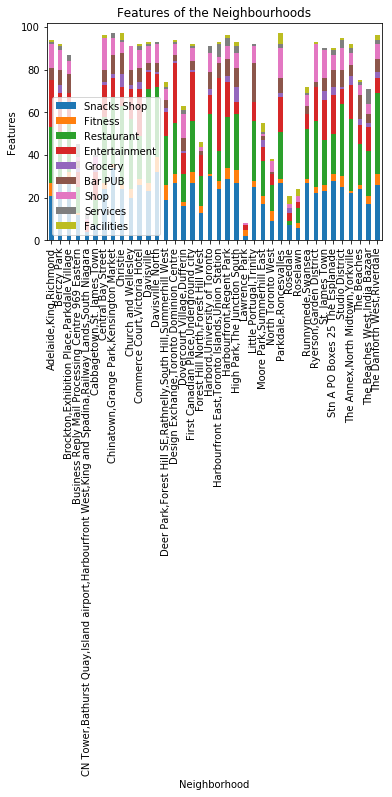

In [38]:
import matplotlib.pyplot as plt
new_toronto_onehot.plot(kind='bar', stacked=True)
plt.ylabel('Features')
plt.title('Features of the Neighbourhoods')

# 5. Clustering

<strong>5.1 Perform K-Mean Clustering with the cluster size 5.</strong>

In [39]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# run k-means clustering
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(new_toronto_onehot)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

<strong>5.2 Group based on K-Mean</strong>

In [40]:
means_df = pd.DataFrame(kmeans.cluster_centers_)
means_df.columns = new_toronto_onehot.columns
means_df.index = ['G1','G2','G3','G4','G5']
means_df['Total Sum'] = means_df.sum(axis = 1)
means_df.sort_values(axis = 0, by = ['Total Sum'], ascending=False)

Snacks Shop   Fitness  Restaurant  Entertainment   Grocery   Bar PUB  \
G5    24.222222  3.777778   35.000000      10.888889  2.111111  5.666667   
G3    25.555556  3.555556   20.888889      22.666667  2.111111  6.111111   
G2    27.875000  3.250000   25.250000       9.875000  2.250000  9.500000   
G4    13.750000  3.250000   15.375000       9.250000  1.375000  3.000000   
G1     4.750000  1.250000    2.250000       3.500000  0.500000  0.000000   

        Shop  Services  Facilities  Total Sum  
G5  9.888889  1.222222    1.222222  94.000000  
G3  8.444444  2.000000    1.333333  92.666667  
G2  6.750000  2.250000    0.875000  87.875000  
G4  4.375000  2.250000    1.375000  54.000000  
G1  1.750000  0.500000    1.750000  16.250000

<strong>5.3 Reset the index and create new data frame to find the total.</strong>

In [41]:
new_means_df = means_df.rename_axis('Group').reset_index()

In [42]:
new_groups=new_means_df['Group']
new_total_sum=new_means_df['Total Sum']


<strong>5.4 Visual representation of the Groups</strong>

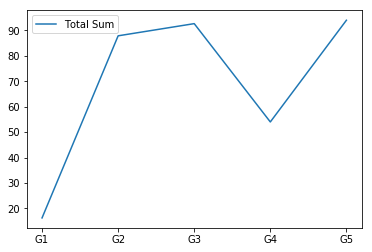

In [43]:
fig, ax = plt.subplots()
ax.plot(new_groups, new_total_sum, label="Total Sum")

ax.legend()

plt.show()

<strong>5.5 Find the Groups for all Neighbourhoods.</strong>

In [44]:
neighborhood_summary = pd.DataFrame([toronto_onehot.index, 1 + kmeans.labels_]).T
neighborhood_summary.columns = ['Neighbourhood', 'Group']
neighborhood_summary

Neighbourhood Group
0                              Adelaide,King,Richmond     3
1                                         Berczy Park     3
2          Brockton,Exhibition Place,Parkdale Village     2
3   Business Reply Mail Processing Centre 969 Eastern     4
4   CN Tower,Bathurst Quay,Island airport,Harbourf...     1
5                          Cabbagetown,St. James Town     4
6                                  Central Bay Street     5
7             Chinatown,Grange Park,Kensington Market     2
8                                            Christie     5
9                                Church and Wellesley     5
10                      Commerce Court,Victoria Hotel     3
11                                         Davisville     5
12                                   Davisville North     5
13  Deer Park,Forest Hill SE,Rathnelly,South Hill,...     4
14            Design Exchange,Toronto Dominion Centre     3
15                        Dovercourt Village,Dufferin     4
16              First Canadian Place,Underground city     3
17                 Forest Hill North,Forest Hill West     4
18                      Harbord,University of Toronto     2
19    Harbourfront East,Toronto Islands,Union Station     3
20                           Harbourfront,Regent Park     2
21                       High Park,The Junction South     2
22                                      Lawrence Park     1
23                            Little Portugal,Trinity     2
24                         Moore Park,Summerhill East     4
25                                 North Toronto West     4
26                              Parkdale,Roncesvalles     3
27                                           Rosedale     1
28                                           Roselawn     1
29                                  Runnymede,Swansea     2
30                            Ryerson,Garden District     5
31                                     St. James Town     3
32                    Stn A PO Boxes 25 The Esplanade     3
33                                    Studio District     5
34                  The Annex,North Midtown,Yorkville     5
35                                        The Beaches     2
36                      The Beaches West,India Bazaar     4
37                        The Danforth West,Riverdale     5

<strong>5.6 Visual representation of the Neighbourhoods and their Groups</strong>

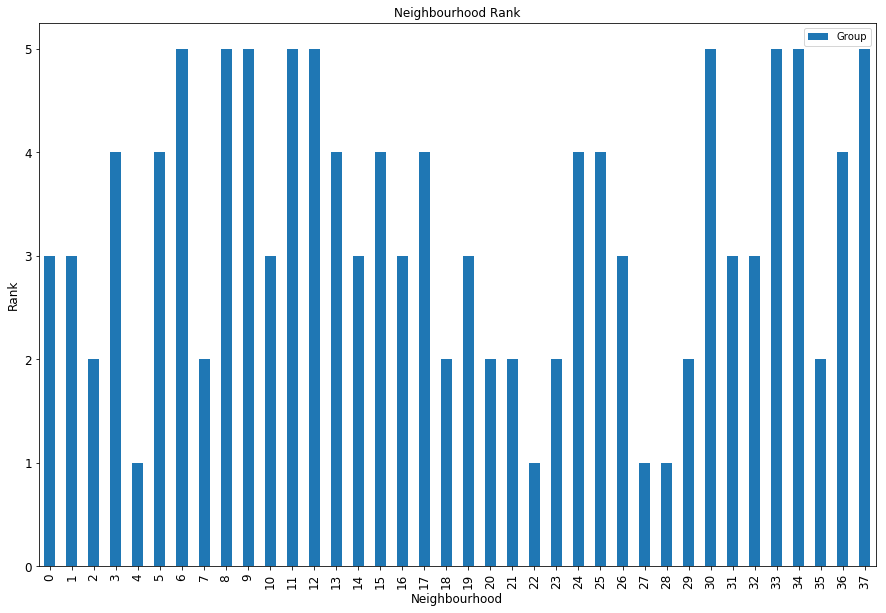

In [45]:
neighborhood_summary_plot=neighborhood_summary

ax = neighborhood_summary_plot[['Neighbourhood','Group']].plot(kind='bar', title ="Neighbourhood Rank", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Neighbourhood", fontsize=12)
ax.set_ylabel("Rank", fontsize=12)
plt.show()

# 6. Find the best Neighbourhoods

<strong>6.1  Find the Neighbourhoods for the top Group</strong>

In [46]:
neighborhood_summary[neighborhood_summary['Group'] == 5]

Neighbourhood Group
6                  Central Bay Street     5
8                            Christie     5
9                Church and Wellesley     5
11                         Davisville     5
12                   Davisville North     5
30            Ryerson,Garden District     5
33                    Studio District     5
34  The Annex,North Midtown,Yorkville     5
37        The Danforth West,Riverdale     5

In [47]:
new_neighborhood_summary=neighborhood_summary
new_df_toronto=df_toronto
new_neighborhood_summary.head()
new_df_toronto.head()
display(new_neighborhood_summary, new_df_toronto)

Neighbourhood Group
0                              Adelaide,King,Richmond     3
1                                         Berczy Park     3
2          Brockton,Exhibition Place,Parkdale Village     2
3   Business Reply Mail Processing Centre 969 Eastern     4
4   CN Tower,Bathurst Quay,Island airport,Harbourf...     1
5                          Cabbagetown,St. James Town     4
6                                  Central Bay Street     5
7             Chinatown,Grange Park,Kensington Market     2
8                                            Christie     5
9                                Church and Wellesley     5
10                      Commerce Court,Victoria Hotel     3
11                                         Davisville     5
12                                   Davisville North     5
13  Deer Park,Forest Hill SE,Rathnelly,South Hill,...     4
14            Design Exchange,Toronto Dominion Centre     3
15                        Dovercourt Village,Dufferin     4
16              First Canadian Place,Underground city     3
17                 Forest Hill North,Forest Hill West     4
18                      Harbord,University of Toronto     2
19    Harbourfront East,Toronto Islands,Union Station     3
20                           Harbourfront,Regent Park     2
21                       High Park,The Junction South     2
22                                      Lawrence Park     1
23                            Little Portugal,Trinity     2
24                         Moore Park,Summerhill East     4
25                                 North Toronto West     4
26                              Parkdale,Roncesvalles     3
27                                           Rosedale     1
28                                           Roselawn     1
29                                  Runnymede,Swansea     2
30                            Ryerson,Garden District     5
31                                     St. James Town     3
32                    Stn A PO Boxes 25 The Esplanade     3
33                                    Studio District     5
34                  The Annex,North Midtown,Yorkville     5
35                                        The Beaches     2
36                      The Beaches West,India Bazaar     4
37                        The Danforth West,Riverdale     5

0   Postcode           Borough  \
2        M5A  Downtown Toronto   
9        M5B  Downtown Toronto   
15       M5C  Downtown Toronto   
19       M4E      East Toronto   
20       M5E  Downtown Toronto   
24       M5G  Downtown Toronto   
25       M6G  Downtown Toronto   
30       M5H  Downtown Toronto   
31       M6H      West Toronto   
36       M5J  Downtown Toronto   
37       M6J      West Toronto   
41       M4K      East Toronto   
42       M5K  Downtown Toronto   
43       M6K      West Toronto   
47       M4L      East Toronto   
48       M5L  Downtown Toronto   
54       M4M      East Toronto   
61       M4N   Central Toronto   
62       M5N   Central Toronto   
67       M4P   Central Toronto   
68       M5P   Central Toronto   
69       M6P      West Toronto   
73       M4R   Central Toronto   
74       M5R   Central Toronto   
75       M6R      West Toronto   
79       M4S   Central Toronto   
80       M5S  Downtown Toronto   
81       M6S      West Toronto   
83       M4T   Central Toronto   
84       M5T  Downtown Toronto   
86       M4V   Central Toronto   
87       M5V  Downtown Toronto   
91       M4W  Downtown Toronto   
92       M5W  Downtown Toronto   
96       M4X  Downtown Toronto   
97       M5X  Downtown Toronto   
99       M4Y  Downtown Toronto   
100      M7Y      East Toronto   

0                                        Neighbourhood Latitude Longitude  \
2                             Harbourfront,Regent Park  43.6543  -79.3606   
9                              Ryerson,Garden District  43.6572  -79.3789   
15                                      St. James Town  43.6515  -79.3754   
19                                         The Beaches  43.6764   -79.293   
20                                         Berczy Park  43.6448  -79.3733   
24                                  Central Bay Street   43.658  -79.3874   
25                                            Christie  43.6695  -79.4226   
30                              Adelaide,King,Richmond  43.6506  -79.3846   
31                         Dovercourt Village,Dufferin   43.669  -79.4423   
36     Harbourfront East,Toronto Islands,Union Station  43.6408  -79.3818   
37                             Little Portugal,Trinity  43.6479  -79.4197   
41                         The Danforth West,Riverdale  43.6796  -79.3522   
42             Design Exchange,Toronto Dominion Centre  43.6472  -79.3816   
43          Brockton,Exhibition Place,Parkdale Village  43.6368  -79.4282   
47                       The Beaches West,India Bazaar   43.669  -79.3156   
48                       Commerce Court,Victoria Hotel  43.6482  -79.3798   
54                                     Studio District  43.6595  -79.3409   
61                                       Lawrence Park   43.728  -79.3888   
62                                            Roselawn  43.7117  -79.4169   
67                                    Davisville North  43.7128  -79.3902   
68                  Forest Hill North,Forest Hill West  43.6969  -79.4113   
69                        High Park,The Junction South  43.6616  -79.4648   
73                                  North Toronto West  43.7154  -79.4057   
74                   The Annex,North Midtown,Yorkville  43.6727  -79.4057   
75                               Parkdale,Roncesvalles   43.649  -79.4563   
79                                          Davisville  43.7043  -79.3888   
80                       Harbord,University of Toronto  43.6627     -79.4   
81                                   Runnymede,Swansea  43.6516  -79.4844   
83                          Moore Park,Summerhill East  43.6896  -79.3832   
84             Chinatown,Grange Park,Kensington Market  43.6532     -79.4   
86   Deer Park,Forest Hill SE,Rathnelly,South Hill,...  43.6864     -79.4   
87   CN Tower,Bathurst Quay,Island airport,Harbourf...  43.6289  -79.3944   
91                                            Rosedale  43.6796  -79.3775   
92                     Stn A PO Boxes 25 The Esplanade 

<strong>6.2 Find the Latitude and Longitude of the Neighbourhoods by merginf them with Toronto Data.</strong>

In [48]:
best_neighbourhoods=pd.merge(new_df_toronto, new_neighborhood_summary, on='Neighbourhood')

In [49]:
best_neighbourhoods.head()

Postcode           Borough             Neighbourhood Latitude Longitude  \
0      M5A  Downtown Toronto  Harbourfront,Regent Park  43.6543  -79.3606   
1      M5B  Downtown Toronto   Ryerson,Garden District  43.6572  -79.3789   
2      M5C  Downtown Toronto            St. James Town  43.6515  -79.3754   
3      M4E      East Toronto               The Beaches  43.6764   -79.293   
4      M5E  Downtown Toronto               Berczy Park  43.6448  -79.3733   

   Cluster Group  
0        0     2  
1        0     5  
2        0     3  
3        3     2  
4        0     3

In [50]:
best_neighbourhoods[best_neighbourhoods['Group'] == 1]

Postcode           Borough  \
17      M4N   Central Toronto   
18      M5N   Central Toronto   
31      M5V  Downtown Toronto   
32      M4W  Downtown Toronto   

                                        Neighbourhood Latitude Longitude  \
17                                      Lawrence Park   43.728  -79.3888   
18                                           Roselawn  43.7117  -79.4169   
31  CN Tower,Bathurst Quay,Island airport,Harbourf...  43.6289  -79.3944   
32                                           Rosedale  43.6796  -79.3775   

    Cluster Group  
17        1     1  
18        1     1  
31        0     1  
32        0     1

<strong>6.3 Visualize the best Neighbourhoods in the Toronto Map.</strong>

In [51]:
group_array=np.array(best_neighbourhoods['Group'], np.int32)
group_array

array([2, 5, 3, 2, 3, 5, 5, 3, 4, 3, 2, 5, 3, 2, 4, 3, 5, 1, 1, 5, 4, 2, 4,
       5, 3, 5, 2, 2, 4, 2, 4, 1, 1, 3, 4, 3, 5, 4], dtype=int32)

In [52]:
new_toronto_map = folium.Map(location=[43.65, -79.4], zoom_start=12)

X = best_neighbourhoods['Latitude']
Y = best_neighbourhoods['Longitude']
Z = np.stack((X, Y), axis=1)

clusters = group_array
colors = ['gray', 'red', 'orange', 'purple', 'blue', 'green' ]
best_neighbourhoods['Group'] = clusters

for latitude, longitude, group, neighbourhood in zip(best_neighbourhoods['Latitude'], best_neighbourhoods['Longitude'], best_neighbourhoods['Group'], best_neighbourhoods['Neighbourhood']):
    label = folium.Popup(group, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[group],
        fill_opacity=0.7).add_to(new_toronto_map)  

new_toronto_map